In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback, EarlyStopping

In [ ]:
df = pd.read_parquet("/content/C__Users_HP_Downloads_cleaned.parquet")
df

,lyric_clean
0,he said the way my blue eyes shinx put those g...
1,state the obvious i did not get my perfect fan...
2,drew looks at me i fake a smile so he will not...
3,i do not know what i want so do not ask me bec...
4,you have a way of coming easily to me and when...
...,...
127,what did you think i would say to that does a ...
128,keep your helmet keep your life son just a fle...
129,betty i will not make assumptions about why yo...
130,our coming of age has come and gone suddenly t...


## Using LSTM for Lyric Generation

In this project, I'm going to use LSTM (Long Short-Term Memory) networks for generating lyrics in the style of Taylor Swift.

### What is an LSTM?

LSTMs are a special kind of neural network that excel in learning from sequences, like sentences in a song. What LSTMs do with data—they remember not just the immediate past but also information from way back.

### How We Prepare Training Data and Labels

1. **Tokenization**: First, we convert the lyrics into a format that our LSTM model can understand. We do this by breaking down the lyrics into individual words and then converting each word into a unique number.

2. **Creating Input Sequences**: We then create sequences of these numbers. Each sequence is a part of a lyric line, and with each step, we add one word to the sequence. This way, the model learns to predict the next word in a sequence.

3. **Padding**: Since not all sequences are of the same length, we make them uniform by adding zeroes to the shorter sequences, a process known as padding.

4. **Splitting the Data**: The sequences are then divided into two parts: predictors and the label. The predictors are the sequences of numbers we input into the model, and the label is the next number that the model needs to predict.

5. **One-Hot Encoding**: Finally, we convert labels into a format where all possibilities are represented as zeroes, except the actual label, which is represented as a one.

6. **Train-Test Split**: Lastly, we split our dataset into a training set and a validation set. The training set is used to train the model, while the validation set is used to test its performance and accuracy.


In [ ]:
combined_lyrics = ' '.join(df['lyric_clean'])
tokenizer = Tokenizer()
tokenizer.fit_on_texts([combined_lyrics])
total_words = len(tokenizer.word_index) + 1
input_sequences = []
for line in df['lyric_clean']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_len = max(len(x) for x in input_sequences)
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
label = to_categorical(label, num_classes=total_words)

# Splitting Data
X_train, X_val, y_train, y_val = train_test_split(predictors, label, test_size=0.2, random_state=42)

In [ ]:
X_train

array([[  0,   0,   0, ..., 201, 125, 773],
       [  0,   0,   0, ...,  85,   5,   6],
       [  0,   0,   0, ..., 262,   8,  76],
       ...,
       [  0,   0,   0, ...,   8, 130,   6],
       [  0,   0,   0, ..., 133, 647, 260],
       [  0,   0,   0, ..., 148,  43,  36]], dtype=int32)

In [ ]:
# Perplexity Calculation
class Perplexity(Callback):
    def on_epoch_end(self, epoch, logs={}):
        cross_entropy = logs.get('loss')
        perplexity = np.exp(cross_entropy)
        print(f' - perplexity: {perplexity}')

def viz_metrics(history):
    # Visualizing Training and Validation Metrics
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

def train(model):
  earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto', restore_best_weights=True)
  history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[earlystop, Perplexity()])
  return history

def generate(model, seed_text):
  next_words = 100  # Number of words you want to generate

  for _ in range(next_words):
      # Tokenize the current seed text
      token_list = tokenizer.texts_to_sequences([seed_text])[0]

      # Pad the sequence
      token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

      # Predict the next word (as probabilities)
      probabilities = model.predict(token_list, verbose=0)

      # Get the index of the most likely next word
      predicted = np.argmax(probabilities, axis=-1)[0]

      # Convert the predicted token to a word
      output_word = ""
      for word, index in tokenizer.word_index.items():
          if index == predicted:
              output_word = word
              break

      # Update the seed text
      seed_text += " " + output_word

  return seed_text


def sample_with_temperature(probabilities, temperature=1.0):
    # Adjust the probabilities with temperature
    probabilities = np.asarray(probabilities).astype('float64')
    probabilities = np.log(probabilities + 1e-10) / temperature  # Adding a small constant to avoid division by zero
    exp_probs = np.exp(probabilities)
    probabilities = exp_probs / np.sum(exp_probs)

    # Sample the next word based on the adjusted probabilities
    choices = range(len(probabilities))
    next_word = np.random.choice(choices, p=probabilities)

    return next_word

def generate_with_temperature(model, seed_text, temperature=1.0):

    next_words = 100
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

        probabilities = model.predict(token_list, verbose=0)[0]

        # Use temperature to adjust the probabilities and sample the next word
        predicted = sample_with_temperature(probabilities, temperature=temperature)

        # Convert the predicted token to a word and update the seed text
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word

    return seed_text


In [ ]:
from IPython.display import display
# (Make sure the clean_generated_text() function from EDA_taylor is imported or copied here too)

def generate_clean_lyrics(prompt):
    """
    Takes a text prompt, generates lyrics using the model,
    cleans the output, and returns only the words.
    """
    # Assuming you already have a function or pipeline like 'model.generate()' or similar
    # Replace 'model.generate(prompt)' with your actual generation call
    generated = model.generate(prompt)

    # Clean the generated output
    cleaned_output = clean_generated_text(generated)

    print("🔹 Original output:")
    print(generated)
    print("\n✨ Cleaned output:")
    print(cleaned_output)

    return cleaned_output


## Baseline model


### Model Architecture

1. **Input Layer (Embedding Layer)**:
   - `Embedding`: The first layer is an Embedding layer, which is used to convert our input data into dense vectors of fixed size. Here, `total_words` is the size of the vocabulary, and `100` is the dimensionality of the embedding vectors. The `input_length` is set to `max_sequence_len - 1`, which is the length of the input sequences.

2. **LSTM Layer**:
   - `LSTM`: After the Embedding layer, we have an LSTM layer with 150 units. This layer will process the sequence of word embeddings output by the previous layer.
3. **Dropout for Regularization**:
   - `Dropout(0.1)`: Following the first LSTM layer, we set a Dropout layer with a dropout rate of 0.1 (10%). Dropout is a regularization technique where randomly selected neurons are ignored during training, which helps in preventing overfitting.

3. **Output Layer (Dense Layer)**:
   - `Dense`: The final layer is a Dense layer with a softmax activation function. The size of this layer is equal to `total_words`, which represents the total number of unique words in the vocabulary. The softmax activation function will output a probability distribution over the vocabulary for the next word in the sequence.

The loss function used is `categorical_crossentropy`, which is suitable for multi-class classification problems. We use the `adam` optimizer, which is an algorithm for first-order gradient-based optimization of stochastic objective functions. The metrics we are interested in monitoring is `accuracy`.

### Early Stopping

- `EarlyStopping`: EarlyStopping is a callback that stops the training process when a monitored metric has stopped improving. We are monitoring the validation loss (`val_loss`), and if the loss does not decrease (`min_delta=0`) for three epochs (`patience=3`), the training will stop. The `verbose=1` setting allows us to see the output of the early stopping events. The `mode='auto'` will determine the direction of improvement automatically and `restore_best_weights=True` ensures that the model's weights will revert to those that yielded the lowest validation loss.

If the `val_loss` begins to increase as training proceeds, it can be an indicator of overfitting.

### Training the Model

- The model will train for a maximum of 100 epochs on the training data `X_train` and `y_train`.

- During training, the model's performance is also validated using a separate validation set.

-  `Perplexity()` is  a custom callback (not provided in the standard Keras callbacks) which computes the perplexity metric after each epoch, a common evaluation metric in language modeling. A lower perplexity score indicates better predictive performance, as it means the model is more certain about its predictions.



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1266/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0628 - loss: 5.9991 - perplexity: 292.9679588804956
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 49s 33ms/step - accuracy: 0.0628 - loss: 5.9986 - val_accuracy: 0.1213 - val_loss: 5.2198
Epoch 2/100
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.1296 - loss: 5.0502 - perplexity: 141.3841125069087
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 80s 35ms/step - accuracy: 0.1296 - loss: 5.0501 - val_accuracy: 0.1657 - val_loss: 4.8205
Epoch 3/100
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1774 - loss: 4.5213 - perplexity: 86.62375434978378
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 44s 34ms/step - accuracy: 0.1774 - loss: 4.5213 - val_accuracy: 0.2013 - val_loss: 4.5834
Epoch 4/100
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2277 - loss: 4.0789 - perplexity: 56.543693507042214
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.2277 - loss: 4.0788 - val_accuracy: 0.2298 - val_loss: 4.4129
Epoch 5/100
1266/1267 ━━━━━

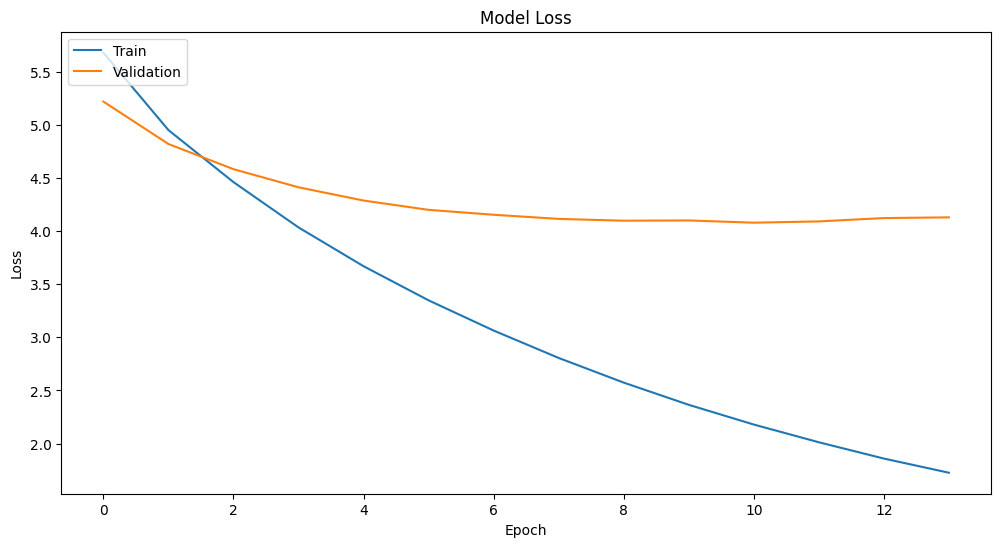

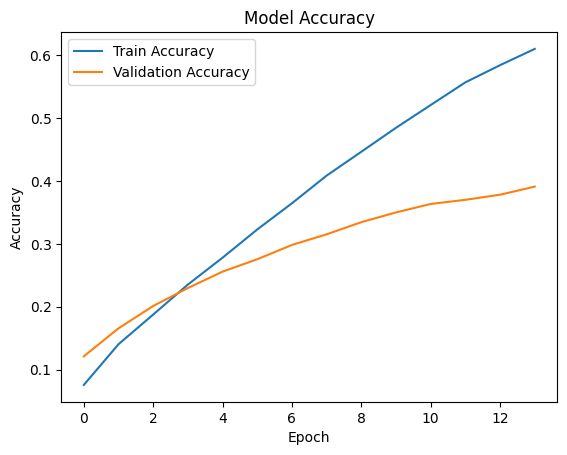

In [ ]:
# Building the Model
baseline_model = Sequential()
baseline_model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
baseline_model.add(LSTM(150))
baseline_model.add(Dropout(0.1))
baseline_model.add(Dense(total_words, activation='softmax'))
baseline_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

baseline_model.summary()

history = train(baseline_model)
viz_metrics(history)